# Process the data into a useable format

In [25]:
import os
import quopri
import emoji
import re
import base64
import email
from bs4 import BeautifulSoup, NavigableString
import pandas as pd

def replace_emojis(text):
    return emoji.demojize(text, delimiters=("", ""))

def replace_urls_based_on_context(html_content):
    soup = BeautifulSoup(html_content, 'lxml')
    for a_tag in soup.find_all('a'):
        href = a_tag.get('href', '')
        url_type = 'UNSAFE_' if href.startswith('http://') else ''
        if a_tag.img:
            a_tag.string = f'{url_type}IMAGE_URL'
        elif isinstance(a_tag.next, NavigableString) and a_tag.next.strip():
            a_tag.string = f'{url_type}LINK_URL'
        else:
            a_tag.string = f'{url_type}BUTTON_URL'
    return str(soup)

def replace_urls_in_text(text):
    # Replace http URLs
    http_url_pattern = re.compile(r'http://\S+')
    text = http_url_pattern.sub('UNSAFE_LINK_URL', text)
    
    # Replace https URLs
    https_url_pattern = re.compile(r'https://\S+')
    text = https_url_pattern.sub('LINK_URL', text)

    return text

def decode_quoted_printable(input_data):
    if isinstance(input_data, bytes):
        return quopri.decodestring(input_data).decode('utf-8', errors='replace')
    else:
        return quopri.decodestring(input_data.encode()).decode('utf-8', errors='replace')

def decode_base64(text):
    return base64.b64decode(text).decode('utf-8', errors='replace')

def clean_text(html_content):
    # Create a BeautifulSoup object
    soup = BeautifulSoup(html_content, 'lxml')
    
    # Remove style tags and their content
    for style_tag in soup.find_all('style'):
        style_tag.decompose()
    
    # Now proceed with extracting text and further cleaning
    text = soup.get_text(separator=' ', strip=True)
    text = replace_emojis(text)
    
    # Decode any quoted-printable text
    text = quopri.decodestring(text.encode()).decode('utf-8', errors='replace')
    
    # Remove any remaining HTML encoded characters
    text = re.sub(r'&[a-zA-Z0-9#]+;', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Strip string of leading/trailing whitespace
    return text.strip()


def calculate_max_nesting_depth(soup):
    def get_depth(element, current_depth):
        children = element.find_all(recursive=False)
        if not children:
            return current_depth
        return max(get_depth(child, current_depth + 1) for child in children)
    return get_depth(soup, 0)

# Function to decode the payload based on its encoding
def decode_payload(payload, encoding):
    print(f"Decoding quoted-printable payload: {payload[0:100]}")  # DEBUG
    print(f"Encoding: {encoding}")  # DEBUG
    if encoding == 'quoted-printable':
        print(f'Encoding is quoted-printable')  # DEBUG
        return decode_quoted_printable(payload)
    elif encoding == 'base64':
        print(f'Encoding is base64')  # DEBUG
        return decode_base64(payload)
    print(f'Encoding is: {encoding} so the default of utf-8 will be used.')  # DEBUG
    return payload.decode('utf-8', errors='replace')


def process_part(part):
    content_type = part.get_content_type()
    content_transfer_encoding = part.get('Content-Transfer-Encoding', '').lower()
    payload = part.get_payload(decode=(content_transfer_encoding != ''))

    if not payload or content_type.startswith("multipart/"):
        return ''

    decoded_payload = decode_payload(payload, content_transfer_encoding)

    if content_type == "text/html":
        soup = BeautifulSoup(decoded_payload, 'lxml')
        text = clean_text(str(soup))
    elif content_type == "text/plain":
        text = replace_urls_in_text(decoded_payload)
        text = replace_emojis(text)
        text = text.strip()
    else:
        print(f"Unsupported content type: {content_type}")
        return ''

    return text

def preprocess_email(filepath, is_warranted_spam):
    try:
        with open(filepath, 'rb') as file:
            raw_email = file.read()
        msg = email.message_from_bytes(raw_email)

        # Extract and clean the subject
        subject = msg.get('Subject', '')
        cleaned_subject = replace_emojis(subject)
        cleaned_subject = replace_urls_in_text(cleaned_subject)

        tag_count, tag_types, max_nesting_depth = 0, {}, 0
        cleaned_body_parts = []

        if msg.is_multipart():
            for part in msg.walk():
                text_part = process_part(part)
                if text_part:
                    cleaned_body_parts.append(text_part)
        else:
            # For non-multipart emails
            text_part = process_part(msg)
            if text_part:
                cleaned_body_parts.append(text_part)

        # Combine the body parts and calculate tag to text ratio
        cleaned_body_text = ' '.join(cleaned_body_parts).strip()
        tag_to_text_ratio = tag_count / len(cleaned_body_text.split()) if cleaned_body_text else 0

        return {
            'subject': cleaned_subject,
            'body_text': cleaned_body_text,
            'tag_count': tag_count,
            'tag_types': tag_types,
            'tag_to_text_ratio': tag_to_text_ratio,
            'max_nesting_depth': max_nesting_depth,
            'target': 1 if is_warranted_spam else 0
        }
    except Exception as e:
        print(f"Error processing file {filepath}: {e}")
        return {
            'subject': '',
            'body_text': '',
            'tag_count': 0,
            'tag_types': {},
            'tag_to_text_ratio': 0,
            'max_nesting_depth': 0,
            'target': 0 if not is_warranted_spam else 1
        }

## Now we need to prepare the data

We need mold the data into a format suitable for training a BERT transformer. We will create a dataframe datastructure do do this.

## This script is best for the primary data

In [28]:
import os
import pandas as pd

# Directory containing the email files
# directory = 'C:\\Users\\ericb\\Desktop\\Research\\Primary@gmail.com\\Cleaned_Mail\\2023\\'
directory = 'C:\\Users\\ericb\\Desktop\\Research\\Primary@gmail.com\\Cleaned_Mail\\2023\\LabelledSpam\\'
output_directory = 'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\data\\test\\warranted_data_test_output\\'


# Iterate over each subdirectory in the directory
for folder in os.listdir(directory):
    folder_path = os.path.join(directory, folder)
    if os.path.isdir(folder_path):
        email_data_list = []

        # Iterate over each file in the subdirectory
        for filename in os.listdir(folder_path):
            # Skip the file if the filename does not end with '.txt'
            if not filename.endswith('.txt'):
                continue

            file_path = os.path.join(folder_path, filename)
            try:
                print(f"Processing file {file_path}") # DEBUG
                preprocessed_email = preprocess_email(file_path, is_warranted_spam=True)


                # Prepare row data as a dictionary
                row_data = {
                    'filename': filename,
                    'subject': preprocessed_email['subject'],
                    'cleaned_text': preprocessed_email['body_text'],
                    'tag_count': preprocessed_email['tag_count'],
                    'tag_to_text_ratio': preprocessed_email['tag_to_text_ratio'],
                    'max_nesting_depth': preprocessed_email['max_nesting_depth'],
                    'target': preprocessed_email['target']
                }
                # Update row data with tag types
                row_data.update(preprocessed_email['tag_types'])

                # Append the row data dictionary to the list
                email_data_list.append(row_data)
            except Exception as e:
                print(f"Error processing file {filename}: {e}")

        # Convert the list of dictionaries to a DataFrame
        email_data = pd.DataFrame(email_data_list)

        # Fill NaN values with 0 for tag counts
        email_data.fillna(0, inplace=True)

        # Save the DataFrame to a CSV file named after the folder 
        csv_file_name = f'processed_emails_warranted_{folder}.csv'

        email_data.to_csv(os.path.join(output_directory, csv_file_name), index=False)

        print(f"Data processing for {folder} complete. Saved to '{csv_file_name}'")
        # print number of rows and columns
        print(email_data.shape)


Processing file C:\Users\ericb\Desktop\Research\Primary@gmail.com\Cleaned_Mail\2023\LabelledSpam\05\0100018821dfdfcf-f774168d-bd2f-4b0a-996e-82209d2749cb-000000@email.amazonses.com.txt
Decoding quoted-printable payload: b'\r\nDear HoneyPotter,<br />\r\n<br />\r\nThank you for registering at the Boxing Forum. Before we can acti'
Encoding: 8bit
Encoding is: 8bit so the default of utf-8 will be used.
Processing file C:\Users\ericb\Desktop\Research\Primary@gmail.com\Cleaned_Mail\2023\LabelledSpam\05\0e32c785aa03c0e6cb578e7c6bf91839f87.20230524220017@mail13.mcsignup.com.txt
Processing file C:\Users\ericb\Desktop\Research\Primary@gmail.com\Cleaned_Mail\2023\LabelledSpam\05\16808452.87050@subscriptions.hhs.gov.txt
Processing file C:\Users\ericb\Desktop\Research\Primary@gmail.com\Cleaned_Mail\2023\LabelledSpam\05\16808799.8210@updates.nhlbi.nih.gov.txt
Processing file C:\Users\ericb\Desktop\Research\Primary@gmail.com\Cleaned_Mail\2023\LabelledSpam\05\16823688.173123@public.govdelivery.com.txt


### Best for the unwarranted data

In [32]:
import os
import pandas as pd

# Base directory and output directory
base_directory = 'C:\\Users\\ericb\\Desktop\\Research\\Bruce\\'
output_directory = 'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\data\\unwarranted_data_NEW\\'

# Iterate over the years 2018 to 2023
for year in range(2018, 2024):
    # Update the directory path to include the year
    directory = os.path.join(base_directory, str(year))

    # Check if the year directory exists
    if not os.path.exists(directory):
        print(f"Directory for year {year} does not exist.")
        continue

    # Iterate over each subdirectory in the year directory
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            email_data_list = []

            # Iterate over each file in the subdirectory
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                try:
                    preprocessed_email = preprocess_email(file_path, is_warranted_spam=False)

                    # Prepare row data as a dictionary
                    row_data = {
                        'filename': filename,
                        'cleaned_text': preprocessed_email['text'],
                        'tag_count': preprocessed_email['tag_count'],
                        'tag_to_text_ratio': preprocessed_email['tag_to_text_ratio'],
                        'max_nesting_depth': preprocessed_email['max_nesting_depth']
                    }
                    # Update row data with tag types
                    row_data.update(preprocessed_email['tag_types'])

                    # Append the row data dictionary to the list
                    email_data_list.append(row_data)
                except Exception as e:
                    print(f"Error processing file {filename}: {e}")

            # Convert the list of dictionaries to a DataFrame
            email_data = pd.DataFrame(email_data_list)

            # Fill NaN values with 0 for tag counts
            email_data.fillna(0, inplace=True)

            # Define the CSV file name to include the year and folder
            csv_file_name = f'processed_emails_unwarranted_{year}_{folder}.csv'

            # Save the DataFrame to a CSV file
            email_data.to_csv(os.path.join(output_directory, csv_file_name), index=False)

            print(f"Data processing for {folder} in {year} complete. Saved to '{csv_file_name}'")
            # Print number of rows and columns
            print(email_data.shape)


c:\Users\ericb\anaconda3\envs\machinelearning_20220719\lib\site-packages\bs4\__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


Data processing for 01 in 2018 complete. Saved to 'processed_emails_unwarranted_2018_01.csv'
(19659, 69)
Data processing for 02 in 2018 complete. Saved to 'processed_emails_unwarranted_2018_02.csv'
(11422, 69)
Data processing for 03 in 2018 complete. Saved to 'processed_emails_unwarranted_2018_03.csv'
(25820, 69)
Data processing for 04 in 2018 complete. Saved to 'processed_emails_unwarranted_2018_04.csv'
(8226, 64)
Data processing for 05 in 2018 complete. Saved to 'processed_emails_unwarranted_2018_05.csv'
(1142, 58)
Data processing for 06 in 2018 complete. Saved to 'processed_emails_unwarranted_2018_06.csv'
(973, 60)
Data processing for 07 in 2018 complete. Saved to 'processed_emails_unwarranted_2018_07.csv'
(1878, 70)
Data processing for 08 in 2018 complete. Saved to 'processed_emails_unwarranted_2018_08.csv'
(1934, 63)
Data processing for 09 in 2018 complete. Saved to 'processed_emails_unwarranted_2018_09.csv'
(1792, 59)
Data processing for 10 in 2018 complete. Saved to 'processed_e

## Sanity check

In [17]:
# open the csv file and read it into a pandas dataframe
df = pd.read_csv('processed_emails_08.csv')
df.head()


Index(['filename', 'cleaned_text', 'tag_count', 'tag_to_text_ratio',
       'max_nesting_depth', 'html', 'head', 'meta', 'title', 'style', 'body',
       'div', 'table', 'tr', 'td', 'a', 'img', 'span', 'br', 'p', 'link', 'b',
       'u', 'font', 'center', 'nobr', 'tbody', 'strong', 'em',
       'grammarly-desktop-integration', 'th', 'form', 'input', 'label',
       'section', 'i', 'h1', 'hr', 'h2', 'h3', 'h4', 'small',
       'forwardtoafriend', 'ul', 'li', 'thead', 's', 'script', 'header',
       'footer', 'block', 'sub', 'address', 'multiline', 'ol', 'sup',
       'picture', 'source', 'g', 'h5', 'blockquote', 'article', 'big',
       'colgroup', 'col', 'h6', 'map', 'area', 'mark', 'svg', 'rect', 'button',
       'time', 'tfoot', 'wbr'],
      dtype='object')


## Curious about word counts to help determine which transformer to use

In [5]:
import pandas as pd
import os
import numpy as np

# Directory containing the email files
directory = 'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\data\\test\\'

print("Starting data processing...")

for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        print(f"Processing file: {filename}")
        try:
            df = pd.read_csv(os.path.join(directory, filename))
            print(f"Data loaded for {filename}.")
            print(f"Shape of DataFrame: {df.shape}")

            # Check if 'cleaned_text' column exists
            if 'cleaned_text' in df.columns:
                # Calculate word counts
                word_counts = df['cleaned_text'].dropna().apply(lambda x: len(x.split()))

                # Calculate max, average, median, and mode of word counts
                max_word_count = word_counts.max()
                avg_word_count = word_counts.mean()
                median_word_count = word_counts.median()
                mode_word_count = word_counts.mode()[0]

                print(f"File: {filename}")
                print(f"Maximum Word Count: {max_word_count}")
                print(f"Average Word Count: {avg_word_count:.2f}")
                print(f"Median Word Count: {median_word_count}")
                print(f"Mode Word Count: {mode_word_count}")
            else:
                print(f"File: {filename} does not contain a 'cleaned_text' column.")
        except Exception as e:
            print(f"Error processing file {filename}: {e}")
        
        print("-" * 30)

print("Data processing complete.")


Starting data processing...
Processing file: cleaned_extracted_info_08.csv
Data loaded for cleaned_extracted_info_08.csv.
Shape of DataFrame: (34262, 15)
File: cleaned_extracted_info_08.csv does not contain a 'cleaned_text' column.
------------------------------
Processing file: combined_data_1.csv
Data loaded for combined_data_1.csv.
Shape of DataFrame: (68524, 84)
File: combined_data_1.csv
Maximum Word Count: 39542
Average Word Count: 918.47
Median Word Count: 542.0
Mode Word Count: 77
------------------------------
Processing file: processed_emails_08.csv
Data loaded for processed_emails_08.csv.
Shape of DataFrame: (34262, 69)
File: processed_emails_08.csv
Maximum Word Count: 39542
Average Word Count: 918.47
Median Word Count: 542.0
Mode Word Count: 77
------------------------------
Data processing complete.


## Combine the various csv files into a homogenous structure

Combine all warranted spam into a uniform structure data structure
Combine all unwarranted spam into a uniform structure data structure

In [15]:
import os
import pandas as pd

# Directories containing the CSV files
directories = [
    'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\data\\warranted_data_NEW\\',
    'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\data\\unwarranted_data_NEW\\'
]

output_directories = [
    'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\cleaned_data\\warranted_data\\',  # Directory where the output CSVs for warranted data will be saved
    'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\cleaned_data\\unwarranted_data\\'  # Directory where the output CSVs for unwarranted data will be saved
]

for input_directory, output_directory in zip(directories, output_directories):
    # Ensure the output directory exists
    os.makedirs(output_directory, exist_ok=True)
    
    # Collect all CSV filenames
    csv_files = [f for f in os.listdir(input_directory) if f.endswith('.csv')]

    # Initialize empty DataFrame for merged data
    merged_df = pd.DataFrame()

    # Load and merge CSVs
    for filename in csv_files:
        filepath = os.path.join(input_directory, filename)
        # Read the CSV file
        df = pd.read_csv(filepath)
        
        # Check if 'filename' column exists, if not, create it
        if 'filename' not in df.columns:
            df['filename'] = filename
        
        # If merged_df is empty, initialize it with the current df
        if merged_df.empty:
            merged_df = df
        else:
            # Merge on 'filename' and other common columns, avoid duplicates
            merged_df = pd.merge(merged_df, df, on=list(set(merged_df.columns) & set(df.columns)), how='outer')

    # Chunking the merged DataFrame and writing to CSV
    output_file = os.path.join(output_directory, 'combined_data.csv')
    chunk_size = 10000  # Define chunk size

    # Write chunks to the output file
    for start in range(0, merged_df.shape[0], chunk_size):
        end = start + chunk_size
        chunk = merged_df[start:end]
        chunk.to_csv(output_file, mode='a', header=start==0, index=False)

    print("Data processing and CSV generation complete for directory: " + input_directory)


Data processing and CSV generation complete for directory: C:\Users\ericb\Desktop\Research\542_Project\data\warranted_data_NEW\
Data processing and CSV generation complete for directory: C:\Users\ericb\Desktop\Research\542_Project\data\unwarranted_data_NEW\


# Visualize the data word count lengths

Starting data processing...
Processing file: combined_data.csv
Data loaded for combined_data.csv.
Shape of DataFrame: (373963, 1086)
Word counts processed for combined_data.csv.
------------------------------
Generating histogram...


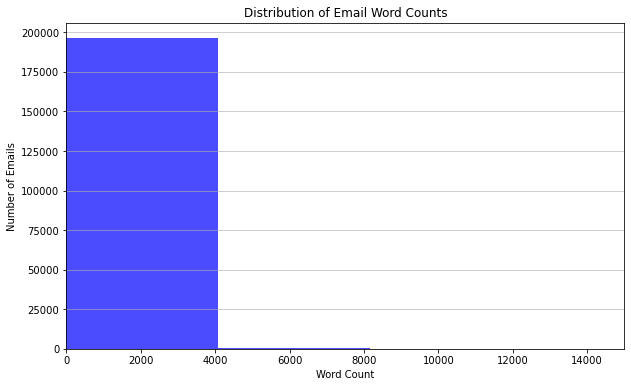

Data processing and histogram generation complete.


In [17]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Directory containing the email files
directory = 'C:\\Users\\ericb\Desktop\\Research\\542_Project\\cleaned_data\\unwarranted_data'

print("Starting data processing...")

# Initialize a list to collect all word counts
all_word_counts = []

for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        print(f"Processing file: {filename}")
        try:
            df = pd.read_csv(os.path.join(directory, filename))
            print(f"Data loaded for {filename}.")
            print(f"Shape of DataFrame: {df.shape}")

            # Check if 'cleaned_text' column exists
            if 'cleaned_text' in df.columns:
                word_counts = df['cleaned_text'].dropna().apply(lambda x: len(x.split()))
                all_word_counts.extend(word_counts)
                print(f"Word counts processed for {filename}.")
            else:
                print(f"File: {filename} does not contain a 'cleaned_text' column.")
        except Exception as e:
            print(f"Error processing file {filename}: {e}")

        print("-" * 30)

print("Generating histogram...")
# Create a histogram of all word counts
plt.figure(figsize=(10, 6))
plt.hist(all_word_counts, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Email Word Counts")
plt.xlabel("Word Count")
plt.ylabel("Number of Emails")
plt.grid(axis='y', alpha=0.75)
plt.xlim(0, 15000)
plt.savefig('email_word_count_distribution.png')
plt.show()

print("Data processing and histogram generation complete.")


## Remove duplicate rows

In [14]:
import os
import pandas as pd

# Directories containing the CSV files
directories = [
    'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\data\\unwarranted_data\\',
    'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\data\\'
]

# Loop through each directory and then each CSV file in the directory
for directory in directories:
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)
            
            # Record the original number of rows
            original_num_rows = df.shape[0]
            
            # Remove duplicates
            df_deduplicated = df.drop_duplicates(subset=['cleaned_text', 'subject'], keep='first')
            
            # Calculate the number of duplicates removed
            num_duplicates_removed = original_num_rows - df_deduplicated.shape[0]
            
            # Save the deduplicated DataFrame back to the CSV file
            df_deduplicated.to_csv(file_path, index=False)
            print(f"Processed {filename}, removed {num_duplicates_removed} duplicates.")


KeyError: Index(['cleaned_text'], dtype='object')

## Ensure all data has the same number of cols

In [18]:
import os
import pandas as pd

# File paths for the two CSV files
file_1 = 'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\cleaned_data\\warranted_data\\combined_data.csv'
file_2 = 'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\cleaned_data\\unwarranted_data\\combined_data.csv'

# Directories
directory_1 = 'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\cleaned_data\\warranted_data\\'
directory_2 = 'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\cleaned_data\\unwarranted_data\\'

# Load the two files to find common columns
df1 = pd.read_csv(file_1, low_memory=False)
df2 = pd.read_csv(file_2, low_memory=False)

print(f'warranted_data.csv shape: {df1.shape}')
print(f'unwarranted_data.csv shape: {df2.shape}')

common_columns = df1.columns.intersection(df2.columns)

print(f'Common columns: {common_columns}')

# Function to process a directory
def process_directory(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)
            filtered_df = df[common_columns]
            filtered_df.to_csv(file_path, index=False)
            print(f"Processed {filename} in {directory}.")
            print(f"Shape of DataFrame: {filtered_df.shape}")

# Process both directories
process_directory(directory_1)
process_directory(directory_2)

print("All CSV files in both directories have been updated with common columns.")



warranted_data.csv shape: (297304, 100)
unwarranted_data.csv shape: (373963, 1086)
Common columns: Index(['filename', 'to', 'from', 'domain of sender', 'subject',
       'date and time', 'number of unsubscribe links',
       'number of undecodable characters', 'tracking pixel present',
       'total links in email', 'email size (bytes)', 'return path',
       'received-spf', 'dkim-signature', 'authentication-results',
       'cleaned_text', 'tag_count', 'tag_to_text_ratio', 'max_nesting_depth',
       'html', 'head', 'meta', 'body', 'div', 'style', 'table', 'tr', 'td',
       'span', 'a', 'b', 'font', 'br', 'h1', 'img', 'p', 'nobr', 'center',
       'sup', 'title', 'link', 'i', 'th', 'tbody', 'strong', 'form', 'input',
       'label', 'section', 'h4', 'h6', 'map', 'area',
       'grammarly-desktop-integration', 'em', 'ul', 'li', 'hr', 'u', 'h3',
       'h2', 'small', 'custom', 'base', 'ol', 'figure', 'multiline', 'header',
       'footer', 'blockquote', 'pre', 'script', 'wbr', 'sub', '

c:\Users\ericb\anaconda3\envs\machinelearning_20220719\lib\site-packages\ipykernel_launcher.py:35: DtypeWarning: Columns (1,2,3,4,5,8,11,12,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.


Processed combined_data.csv in C:\Users\ericb\Desktop\Research\542_Project\cleaned_data\warranted_data\.
Shape of DataFrame: (297304, 95)


c:\Users\ericb\anaconda3\envs\machinelearning_20220719\lib\site-packages\ipykernel_launcher.py:36: DtypeWarning: Columns (1,2,3,4,5,8,11,12,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.


Processed combined_data.csv in C:\Users\ericb\Desktop\Research\542_Project\cleaned_data\unwarranted_data\.
Shape of DataFrame: (373963, 95)
All CSV files in both directories have been updated with common columns.


## Remove some columns and reorganize the data

In [19]:
import os
import pandas as pd

# Directories containing the CSV files
directories = [
    'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\cleaned_data\\unwarranted_data\\',
    'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\cleaned_data\\warranted_data\\'
]

output_directories = [
    'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\cleaned_data\\unwarranted_data\\',  
    'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\cleaned_data\\warranted_data\\' 
]



# Define columns to remove
columns_to_remove = ['to', 'from', 'domain of sender', 'date and time', 'return path', 'received-spf', 'authentication-results', 'grammarly-desktop-integration']


# Process each CSV file
for directory, output_directory in zip(directories, output_directories):
    # Ensure the output directory exists
    os.makedirs(output_directory, exist_ok=True)

    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            input_file = os.path.join(directory, filename)
            output_file = os.path.join(output_directory, filename)

            # Load the CSV file
            df = pd.read_csv(input_file)

            # Remove specified columns
            df.drop(columns=columns_to_remove, errors='ignore', inplace=True)

            # Reorder columns, placing specific columns first, followed by the rest
            first_columns = ['filename', 'cleaned_text', 'subject', 'number of unsubscribe links',
                            'number of undecodable characters', 'tracking pixel present',
                            'total links in email', 'email size (bytes)', 'dkim-signature',
                            'tag_count', 'tag_to_text_ratio', 'max_nesting_depth']
            # Find the rest of the columns
            remaining_columns = [col for col in df.columns if col not in first_columns]

            # ensure last column is the target
            remaining_columns.remove('target')
            remaining_columns.append('target')
            
            # Concatenate the two lists to get the final column order
            final_columns = first_columns + remaining_columns
            # Reindex the dataframe with the new column order
            df = df.reindex(columns=final_columns)

            # Save the cleaned and reordered DataFrame to a new CSV file
            df.to_csv(output_file, index=False)
            print(f"Processed and saved: {output_file}")


c:\Users\ericb\anaconda3\envs\machinelearning_20220719\lib\site-packages\IPython\core\interactiveshell.py:3524: DtypeWarning: Columns (1,2,3,4,5,8,11,12,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Processed and saved: C:\Users\ericb\Desktop\Research\542_Project\cleaned_data\unwarranted_data\combined_data.csv
Processed and saved: C:\Users\ericb\Desktop\Research\542_Project\cleaned_data\warranted_data\combined_data.csv


# Check data size (warranted vs unwarranted)

In [21]:
import os
import pandas as pd

# Directories containing the CSV files
directories = [
    'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\cleaned_data\\warranted_data\\',
    'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\cleaned_data\\unwarranted_data\\'
]

total_rows_warranted = 0
total_rows_unwarranted = 0
warranted_cols = 0
unwarranted_cols = 0

# Loop through each directory and then each CSV file in the directory
for directory in directories:
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)
            if directory == directories[0]:
                total_rows_unwarranted += df.shape[0]
                unwarranted_cols = df.shape[1]
            else:
                total_rows_warranted += df.shape[0]
                warranted_cols = df.shape[1]

            # print last column name
            print(df.columns[-1])
                
print(f"Total rows in unwarranted data: {total_rows_unwarranted}")
print(f"Total rows in warranted data: {total_rows_warranted}")
print(f"Total rows: {total_rows_unwarranted + total_rows_warranted}")
print(f"Total columns in unwarranted data: {unwarranted_cols}")
print(f"Total columns in warranted data: {warranted_cols}")
print(f"Total columns: {unwarranted_cols + warranted_cols}")


c:\Users\ericb\anaconda3\envs\machinelearning_20220719\lib\site-packages\IPython\core\interactiveshell.py:3524: DtypeWarning: Columns (1,2,5,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


label
label
Total rows in unwarranted data: 297304
Total rows in warranted data: 373963
Total rows: 671267
Total columns in unwarranted data: 87
Total columns in warranted data: 87
Total columns: 174


In [11]:
# Open a csv file and remove all rows that don't have '.txt' in the filename
import os
import pandas as pd

# Directories containing the CSV files
directories = [
    'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\data\\warranted_data_NEW\\',
    'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\data\\unwarranted_data_NEW\\'
]

output_directories = [
    'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\data\\warranted_data_NEW\\',
    'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\data\\unwarranted_data_NEW\\' 
]

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Process each CSV file
for directory, output_directory in zip(directories, output_directories):
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            input_file = os.path.join(directory, filename)
            output_file = os.path.join(output_directory, filename)

            # Load the CSV file
            df = pd.read_csv(input_file)
            print(f"Loaded {input_file}.")
            print(f"Shape of DataFrame: {df.shape}")

            # Remove rows that don't have '.txt' in the filename
            df = df[df['filename'].str.contains('.txt')]

            print(f"Shape of DataFrame after filtering: {df.shape}")

            # Save the cleaned and reordered DataFrame to a new CSV file
            df.to_csv(output_file, index=False)
            print(f"Processed and saved: {output_file}")

Loaded C:\Users\ericb\Desktop\Research\542_Project\data\warranted_data_NEW\cleaned_extracted_info_05.csv.
Shape of DataFrame: (7160, 15)
Shape of DataFrame after filtering: (7160, 15)
Processed and saved: C:\Users\ericb\Desktop\Research\542_Project\data\warranted_data_NEW\cleaned_extracted_info_05.csv
Loaded C:\Users\ericb\Desktop\Research\542_Project\data\warranted_data_NEW\cleaned_extracted_info_06.csv.
Shape of DataFrame: (19266, 15)
Shape of DataFrame after filtering: (19266, 15)
Processed and saved: C:\Users\ericb\Desktop\Research\542_Project\data\warranted_data_NEW\cleaned_extracted_info_06.csv
Loaded C:\Users\ericb\Desktop\Research\542_Project\data\warranted_data_NEW\cleaned_extracted_info_07.csv.
Shape of DataFrame: (26704, 15)
Shape of DataFrame after filtering: (26704, 15)
Processed and saved: C:\Users\ericb\Desktop\Research\542_Project\data\warranted_data_NEW\cleaned_extracted_info_07.csv
Loaded C:\Users\ericb\Desktop\Research\542_Project\data\warranted_data_NEW\cleaned_extr

In [2]:
# Read in a csv and a a column to the end of it called target
import os
import pandas as pd

# Directories containing the CSV files
directories = [
    'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\cleaned_data\\warranted_data\\',
    'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\cleaned_data\\unwarranted_data\\'
]

output_directories = [
    'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\cleaned_data\\warranted_data\\',
    'C:\\Users\\ericb\\Desktop\\Research\\542_Project\\cleaned_data\\unwarranted_data\\' 
]

# Process each CSV file
for directory, output_directory in zip(directories, output_directories):
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            input_file = os.path.join(directory, filename)
            output_file = os.path.join(output_directory, filename)

            # Load the CSV file
            df = pd.read_csv(input_file)
            print(f"Loaded {input_file}.")
            print(f"Shape of DataFrame: {df.shape}")

            # Add a column called target
            if 'target' not in df.columns:
                if directory == directories[0]:
                    df['target'] = 1
                else:
                    df['target'] = 0
            else:
                print("target column already exists")

            print(f"Shape of DataFrame after filtering: {df.shape}")

            # Save the cleaned and reordered DataFrame to a new CSV file
            df.to_csv(output_file, index=False)
            print(f"Processed and saved: {output_file}")



c:\Users\ericb\anaconda3\envs\machinelearning_20220719\lib\site-packages\IPython\core\interactiveshell.py:3524: DtypeWarning: Columns (1,2,5,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Loaded C:\Users\ericb\Desktop\Research\542_Project\cleaned_data\warranted_data\warranted_combined_data.csv.
Shape of DataFrame: (297304, 87)
Shape of DataFrame after filtering: (297304, 88)
Processed and saved: C:\Users\ericb\Desktop\Research\542_Project\cleaned_data\warranted_data\warranted_combined_data.csv
Loaded C:\Users\ericb\Desktop\Research\542_Project\cleaned_data\unwarranted_data\unwarranted_combined_data.csv.
Shape of DataFrame: (373963, 87)
Shape of DataFrame after filtering: (373963, 88)
Processed and saved: C:\Users\ericb\Desktop\Research\542_Project\cleaned_data\unwarranted_data\unwarranted_combined_data.csv
